# Predict Student Performance
Arshak Parsa

In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pylab

sns.set_theme(style="whitegrid")


In [393]:
df = pd.read_csv("student-por.csv")

In [394]:
nominal_var = ['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup',
               'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', ]
ordinal_var = ['famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
               'health']
numerical_var = ['age', 'absences', 'G1', 'G2'] # except G3
len(nominal_var),len(ordinal_var),len(numerical_var)

(16, 12, 4)

# EDA

## Phase 1: The First Look

In [395]:
print(df.head())
print(df.shape)
print(df.info())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]
(649, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data c

167 KB memory usage? Bro, that's nothing!

No missing values?! Suspicious!


Some information that I have found on Kaggle:

- 'GP' is Gabriel Pereira and 'MS' is Mousinho da Silveira (See [Fun Facts](#Fun-Facts) at the end of this file)
- The columns 'Dalc' and 'Walc' are related to alcohol consumption! And according to this dataset some kids drink alcohol presumably! Does their mama know they drink alcohol? **NEVER DRINK ALCOHOL KIDS, NEVER**!
- Some columns like 'Medu' and 'Fedu' are categorical, but pandas assumed they are numerical! Let's fix that with the following command!

In [396]:
# Source - https://stackoverflow.com/questions/28910851/python-pandas-changing-some-column-types-to-categories
# Posted by Derek Kaknes
# Retrieved 11/5/2025, License - CC BY-SA 3.0
cat_col = ['Fedu', 'Medu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
df[cat_col] = df[cat_col].apply(lambda x: x.astype('category'))
# Basically this code is for preprocessing but since it affects the output of df.describe(), I run it here.


![](pic/look-lonely-meme.jpg)

In [397]:
df.describe()
# Note that only numerical columns are shown here, because wise data scientists NEVER calculate the mean and std of a categorical data!

,age,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,3.659476,11.399076,11.570108,11.906009
std,1.218138,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,32.000000,19.000000,19.000000,19.000000


In [398]:
print(f"Total duplicated rows: {df.duplicated().sum()}")

# No need to run the following code!
# df = df.drop_duplicates()

Total duplicated rows: 0


## Phase 2: Univariate Analysis (One Variable at a Time)

First, we examine the 'G3' variable, because it's the variable that we want to predict.

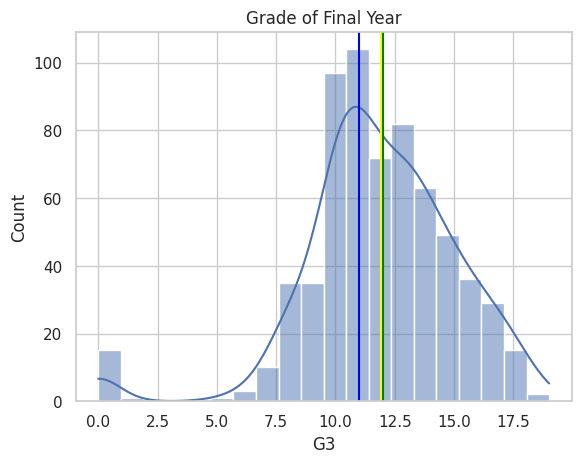

In [399]:
sns.histplot(df['G3'], kde=True, bins=20)
plt.axvline(np.mean(df['G3']), color='yellow')
plt.axvline(np.median(df['G3']), color='green')
plt.axvline(stats.mode(df['G3']).mode, color='blue')
plt.title('Grade of Final Year')
plt.show()

In [400]:
print(stats.skew(df['G3']))

-0.9107980386425641


I can say it's a little left-skewed and unimodal (if we ignore that little bump on the left).


Text(0.5, 1.0, 'Box Plot of Final Grade')

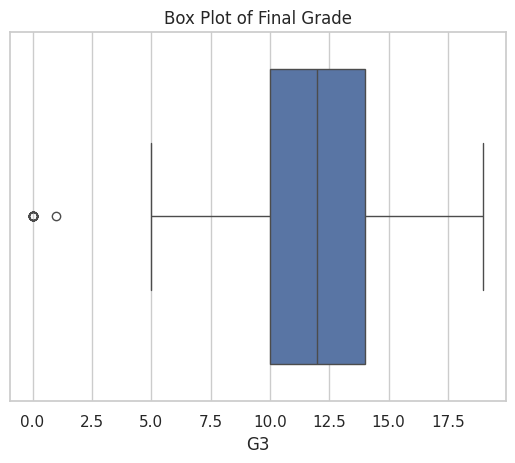

In [401]:
sns.boxplot(x=df['G3'])
plt.title('Box Plot of Final Grade')

Looks like we got outliers (probably backbenchers!)

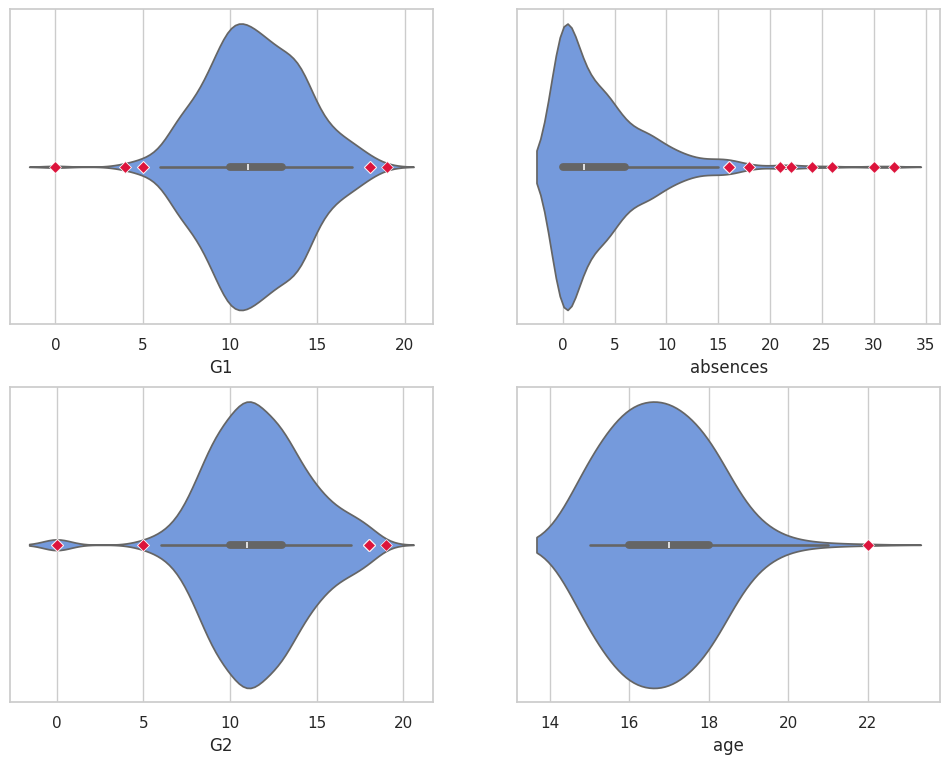

In [402]:
# Source - https://stackoverflow.com/questions/66913456/how-to-mix-the-outliers-from-boxplot-or-not-with-violin-plot
def custom_violinplot(d,ax,xlabel,bw_adjust=1):
    q1, q3 = np.percentile(d, [25, 75])
    whisker_low = q1 - (q3 - q1) * 1.5
    whisker_high = q3 + (q3 - q1) * 1.5
    sns.violinplot(x=d, color='CornflowerBlue', ax=ax, bw_adjust=bw_adjust)
    outliers = d[(d > whisker_high) | (d < whisker_low)]
    sns.scatterplot(x=outliers, y=0, marker='D', color='crimson', ax=ax)
    plt.xlabel(xlabel)
    
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12,9))
custom_violinplot(df['G1'] ,axs[0][0], 'G1')
custom_violinplot(df['G2'] ,axs[1][0], 'G2')
custom_violinplot(df['absences'] ,axs[0][1], 'absences')
custom_violinplot(df['age'] ,axs[1][1], 'age',2)

As you can see we got outliers on our features too! So we might consider not using `StandardScaler`, since it is [sensitive](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-standard-scaler-section) to outliers. 

In [403]:
# Now we examine the categorical variables
cats = np.reshape(df.select_dtypes(['object', 'category']).columns, (7,4))
(cats,cats.shape)
# 33 - 5 = 28 

(array([['school', 'sex', 'address', 'famsize'],
        ['Pstatus', 'Medu', 'Fedu', 'Mjob'],
        ['Fjob', 'reason', 'guardian', 'traveltime'],
        ['studytime', 'failures', 'schoolsup', 'famsup'],
        ['paid', 'activities', 'nursery', 'higher'],
        ['internet', 'romantic', 'famrel', 'freetime'],
        ['goout', 'Dalc', 'Walc', 'health']], dtype=object),
 (7, 4))

In [404]:
#for col in df.select_dtypes(['object', 'category']): 
#    print(df[col].value_counts())
print(df['sex'].value_counts(normalize=True))

sex
F    0.590139
M    0.409861
Name: proportion, dtype: float64


Let's just skip this one! I know a better way!

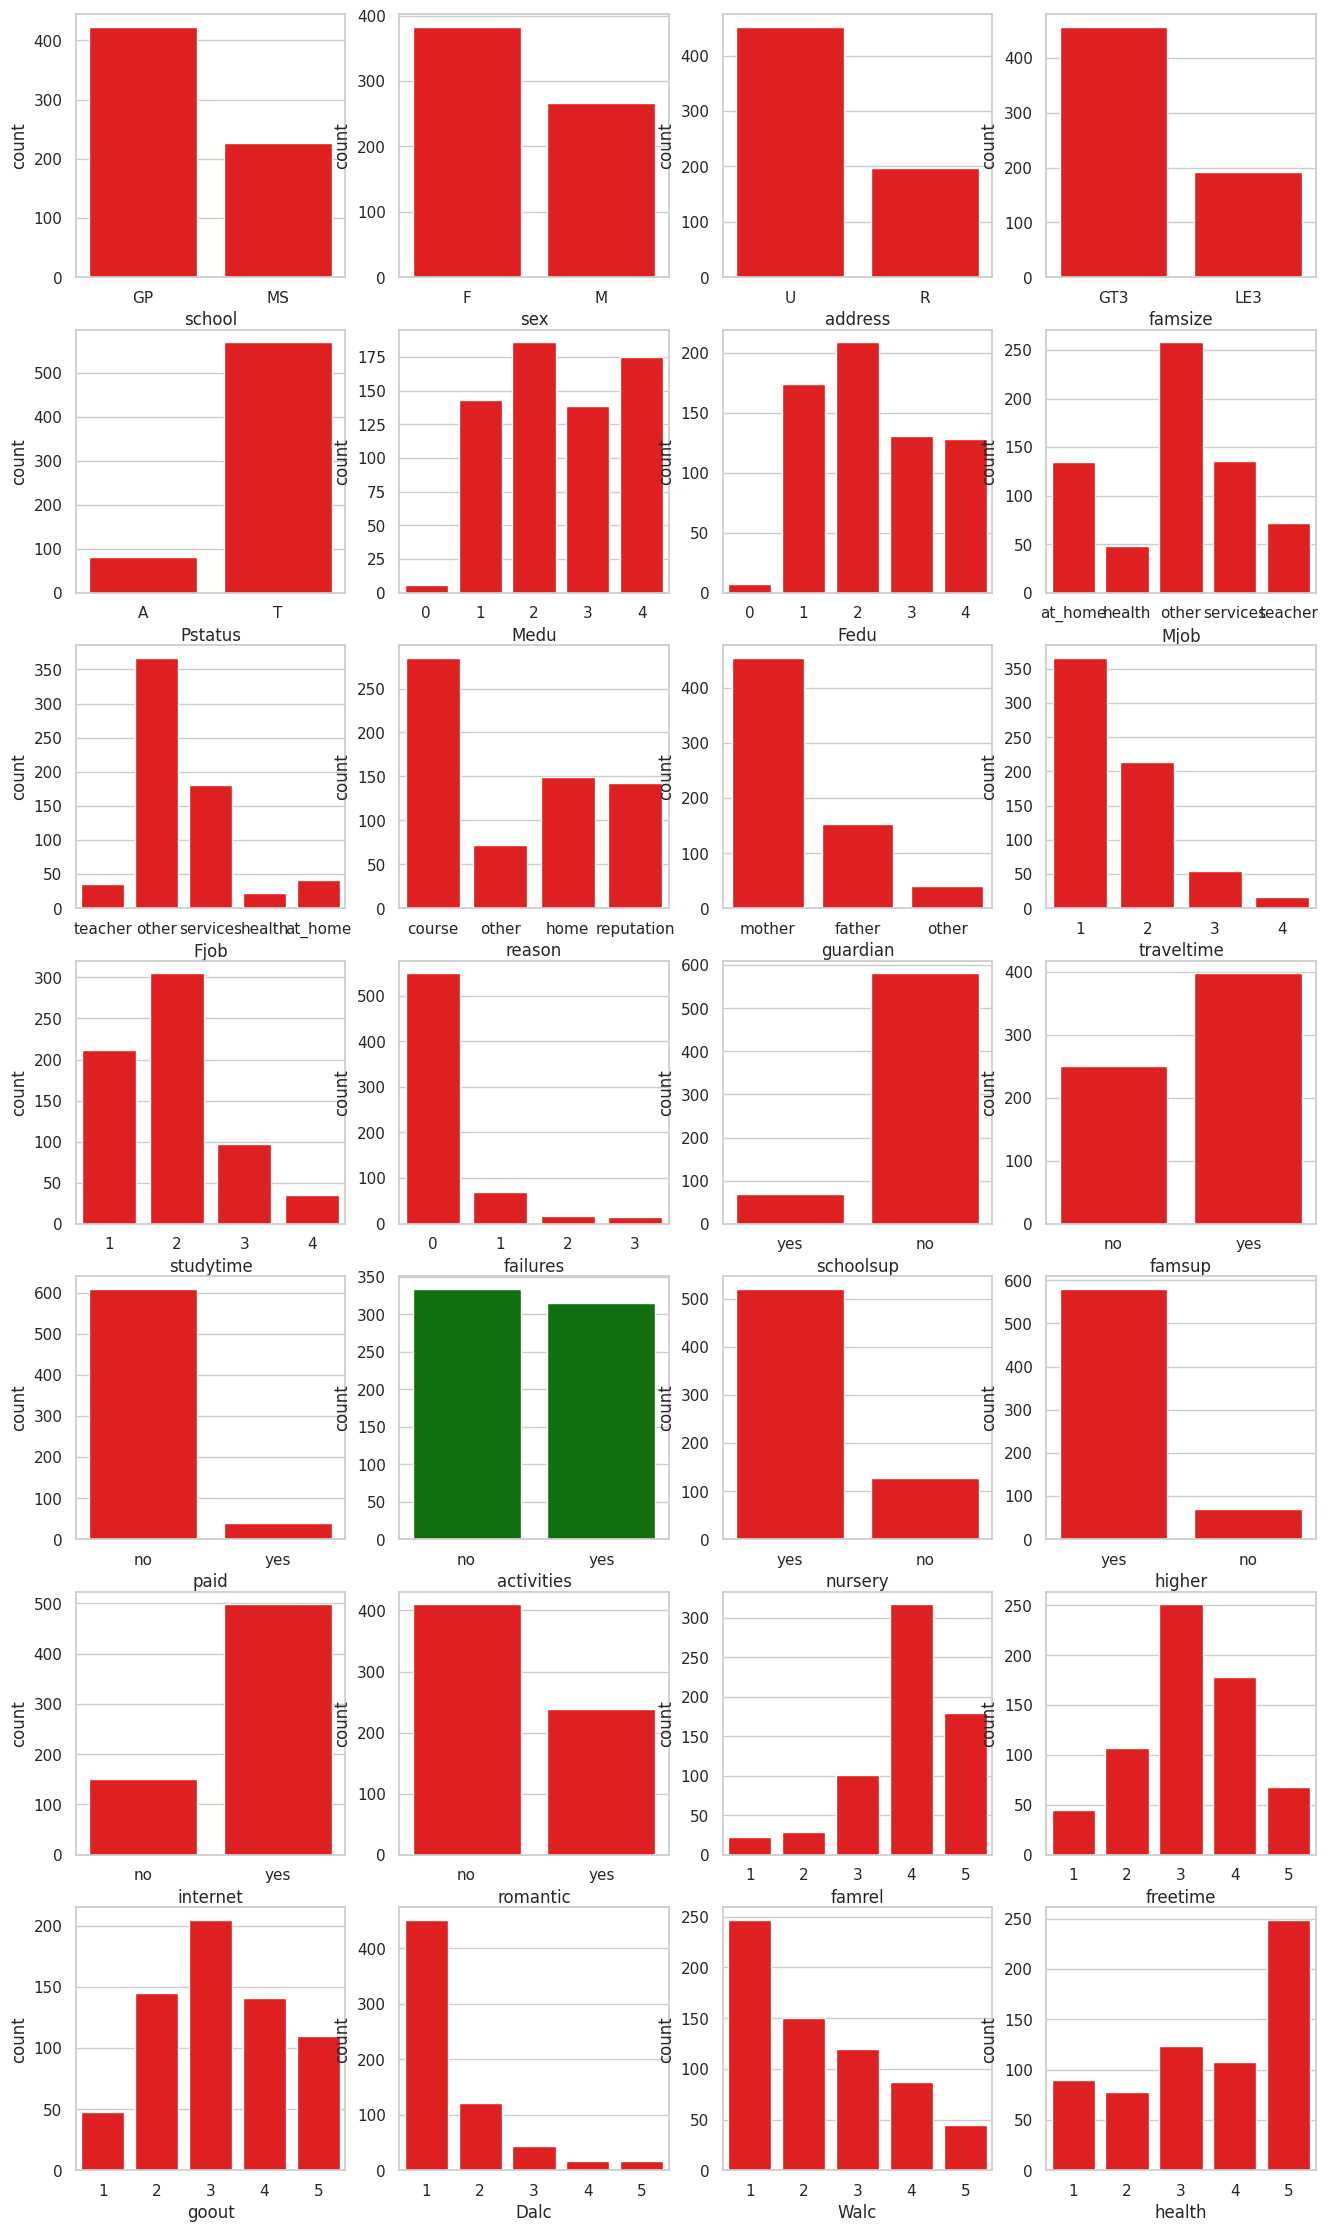

In [405]:
alpha = 4
fig, axs = plt.subplots(ncols = 4, nrows = 7, figsize=(4*alpha, 7*alpha))
for i in range(cats.shape[0]):
    for j in range(cats.shape[1]):
        cl = 'green'
        pval = stats.chisquare(df[cats[i][j]].value_counts().values).pvalue
        if pval < 0.05:
            cl = 'red'
        sns.countplot(x=df[cats[i][j]], ax = axs[i][j], color = cl)



In [406]:
all_comb = 1
for col in (nominal_var+ordinal_var):
    all_comb = all_comb * len(df[col].unique())
all_comb


61440000000000

Looks like almost all of our variables are not balanced!

Red histograms do not follow a uniform distribution.

Fun Fact: we can not balanced them at the same time because we need all possible combination of these categorical variables for which we need 61440000000000 unique samples. Then we can oversample and balance them!

Consider this example, imagine we have only 2 categorical variable, `sex` and `address` and imagine the dataset is like this


In [407]:
example_dataset = pd.DataFrame({
  "sex": ['F', 'F', 'F', 'M', 'M', 'M'],
  "address": ['U', 'U', 'U', 'U', 'U', 'R']
}
)
example_dataset

,sex,address
0,F,U
1,F,U
2,F,U
3,M,U
4,M,U
5,M,R


There is no way to balance this dataset with oversampling! Because if you try to oversample address, you have to imbalance the `sex` variable! The only way is undersampling which is not ideal in our case since we have got only 649 samples :(


We will examine the histogram of our continuous variables in Phase 4!

We will skip Phase 3, because we can plot all the variables in one chart!

## Phase 4: Multivariate Analysis (3+ Variables)

I combine two StackOverflow answers from JohanC together!
Big shout out to JohanC!

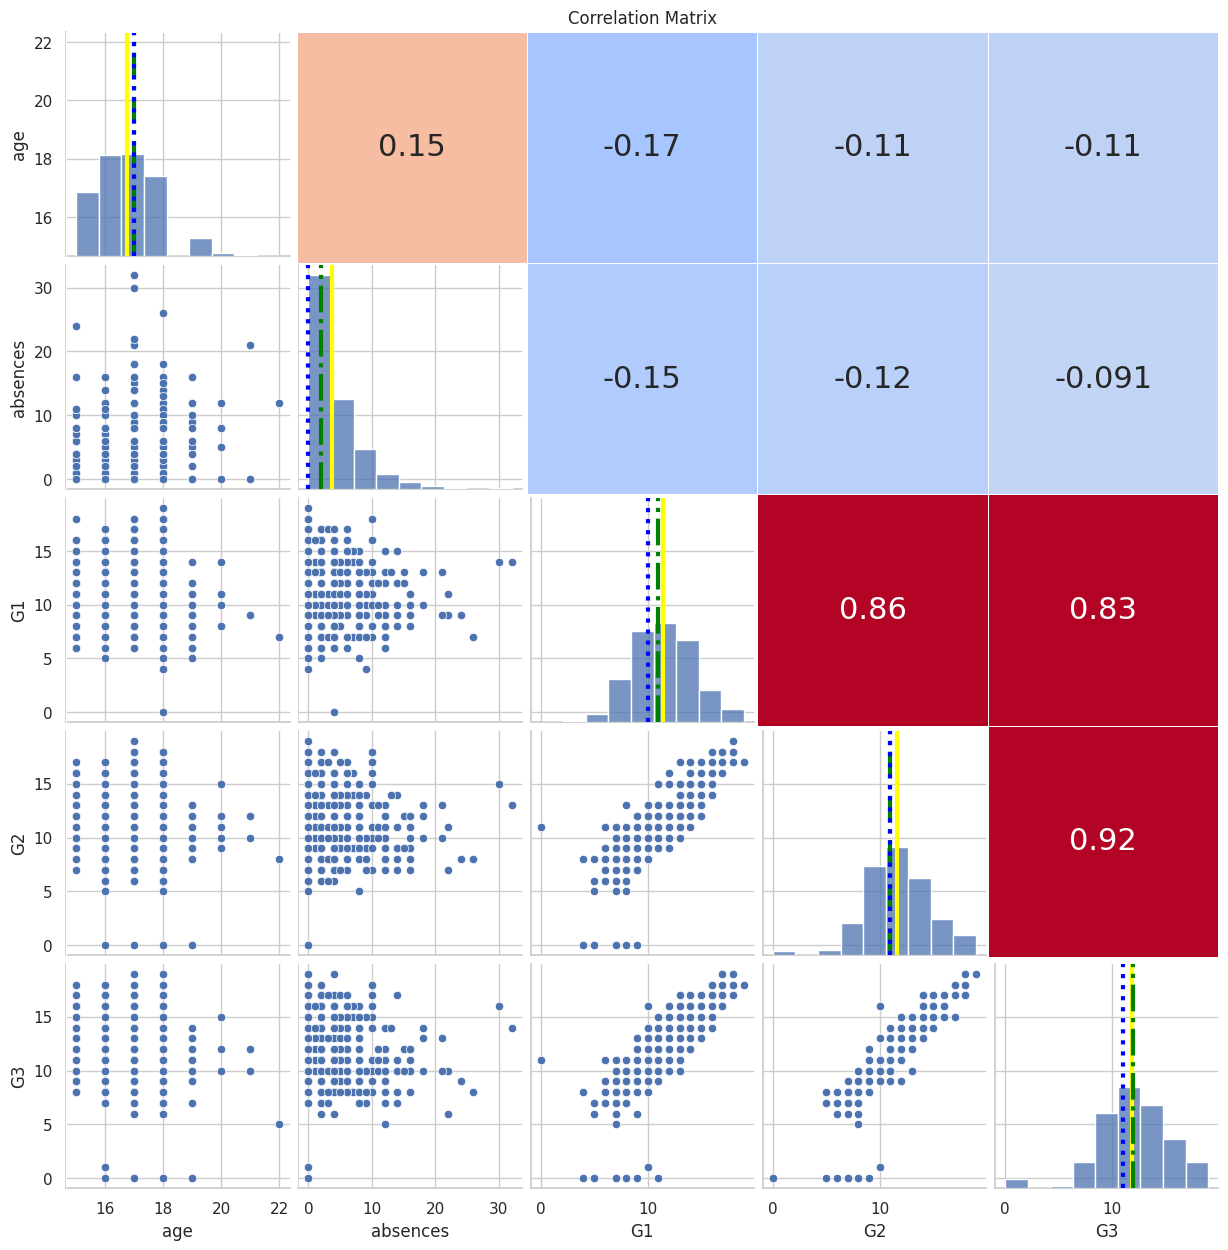

In [408]:
# Source - https://stackoverflow.com/a
# Posted by JohanC, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-11, License - CC BY-SA 4.0
# https://stackoverflow.com/questions/75289515/show-median-and-quantiles-on-seaborn-pairplot-python

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

def update_diag_func(data, label, color):
    plt.axvline(np.mean(data), color='yellow', linewidth=3.0)
    plt.axvline(np.median(data), color='green', linewidth=3.0, linestyle = '-.')
    plt.axvline(stats.mode(data).mode, color='blue', linewidth=3.0 , linestyle = ':')
    

def pairplot_heatmap(d1):
    e = sns.pairplot(d1, diag_kws = {'bins':9})

    e.map_diag(update_diag_func)
    e.map_upper(hide_current_axis)

    (xmin, _), (_, ymax) = e.axes[0, 0].get_position().get_points()
    (_, ymin), (xmax, _) = e.axes[-1, -1].get_position().get_points()

    ax = e.figure.add_axes([xmin, ymin, xmax - xmin, ymax - ymin], facecolor='none')

    corr1 = d1.corr()
    mask1 = np.tril(np.ones_like(corr1, dtype=bool))
    sns.heatmap(corr1, mask=mask1, cmap='coolwarm', vmax=.5, vmin=-.5,
                linewidths=.5, cbar=False, annot=True, annot_kws={'size': 22}, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.xaxis.tick_top()
    # ax.yaxis.tick_right()

    plt.title('Correlation Matrix')
    plt.show()

pairplot_heatmap(df.select_dtypes(['int64']))

What should we look for?
- Features should not be correlated (We don't want multicollinearity)
- We would prefer correlation between our target (`G3`) and features (look at the last row of scatter plots)
- The distribution of target MUST BE normal! (We assume normality of target in regression)
- The distribution of features are preferred to be something like normal or at least symmetric!
- Look for any recognizable pattern in scatter plots!

What do we see!?
- Out of 6 scatter plots, the last scatter plot between `G1` and `G2` is highly correlated which is understandable, those who had a higher grade in past have a higher chance to have a high grade in the future!
- On the last row of scatter plots we can see that `G1` and `G2` have a high positive correlation with `G3` which is again, UNDERSTANDABLE!
- Thanks god, the distribution of `G3` looks fine (Don't worry babe, I will perform a shapiro test to make sure that it's normal!)
- The distribution of `aga`, `G1`, `G2` and `G3` are almost normal, but the distribution of `absences` reminds me of geometric distribution!
- The only pattern I can recognize is linear pattern between `G1`, `G2` and `G3`.

![](pic/drake-meme.png)

Now we perform a shapiro test as I promised!

In [409]:
stats.shapiro(df['G3']).pvalue

np.float64(2.4159862607742257e-17)

I miss R, python's outputs are just ugly :(
    
As you can see shapiro test is suggesting that the `G3` is not normal. Well we can fix that too with some transformation.

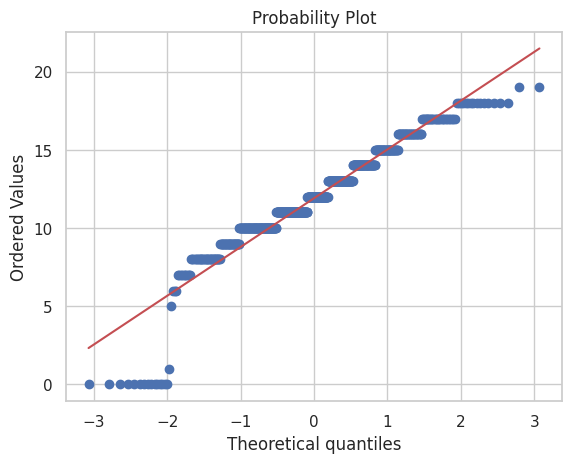

In [410]:
stats.probplot(df['G3'], dist="norm", plot=pylab)
plt.show()

As you can see, qqplot is confirming that `G3` is not normal! 

## Phase 5: Summarize Findings & Plan Action

Goal: Turn your insights into a concrete plan for preprocessing and feature engineering.

Example Findings Summary:

- Target: `G3` seems to have a symmetric distribution, but the shapiro test rejects normality, a transformation on `G3` might handle the situation.
- Missing Data: The dataset is clean, no missing values to impute.
- Categorical: We have 16 nominal and 12 ordinal variables and most of them are not balanced, so we probably need to do oversampling.
- Key Predictors: It seems like `G1` and `G2` could be good candidates for predictors.
- Interactions: Since we've got a lot of categorical variables, we have not examined the interactions.

Resulting Action Plan:

- Preprocessing: We need a transformation for `G3` (We are going to use scikit-learn pipeline). We could also consider performing a transformation on features since two of them are not symmetric.
- Preprocessing: Ordinal encode `ordinal_var` and Label encode `nominal_var` and perform oversampling.
- Model Selection: Since we got a ton of categorical variables, a simple LinearRegression will likely do well, but a DecisionTree or RandomForest will be able to capture the non-linear interactions automatically.

# Preprocessing

In [411]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import *
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Note : We will use `imblearn.pipeline` because it can do everything sklearn does plus resampling (See [this](https://medium.com/@banjiolaniyan123/sklearn-vs-imblearn-pipeline-preventing-data-leakage-in-imbalanced-datasets-b4272484e985))

In [412]:
print(df.isnull().sum().sum())

0


Pipeline does not support transformation on target variable so we transform it right here, but we DO NOT TOUCH `y_test` because I have data leakage phobia!

In [413]:
y = df['G3']

X = df.drop('G3', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.4,     
    random_state=5
)

y_transformer = PowerTransformer()

y_train_old, y_train = y_train.copy(), (pd.DataFrame(y_transformer.fit_transform(pd.DataFrame(y_train))))

print(f"Training set shape (X): {X_train.shape}")
print(f"Testing set shape (X): {X_test.shape}")

Training set shape (X): (389, 32)
Testing set shape (X): (260, 32)


Ok, here is our plan:

First we will create 5 different preprocessors to test which one is the best.

Then we test `PowerTransformer` and `RobustScaler` and see how they change our data.

### Create the pipelines

The first preprocessor is going to be the best that we could create, we will choose every part of it wisely.

We will create a pipeline for each type of data. We also may consider scaling the data with `RobustScaler` because it's not that sensitive to outliers.

`LabelEncoder` is a transformer that is not intended to be used on features, only on supervised learning targets (See [this](https://github.com/scikit-learn/scikit-learn/issues/12720)). We will use `OneHotEncoder` instead.

For transformation, we are going to choose `PowerTransformer` since it will make our data more Gaussian-like.

Note :  `PowerTransformer` should also transform our target variable because regression assumes normality of dependent variable for doing inference.

As I have said, I don't expect oversampling help that much so I exclude it here.

In [414]:

numerical_pipeline = Pipeline([
    # No missing data ,no Imputers
    # I added this to make box-cox possible but the results of box-cox don't make any significant changes
    #('pre-transformer', FunctionTransformer(func = (lambda x: x+1), feature_names_out = 'one-to-one')), 
    ('transformer', PowerTransformer()),
    ('scaler', RobustScaler()),
])

nominal_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('encoder', OneHotEncoder())
])

ordinal_pipeline = Pipeline([
    # No missing data ,no Imputers
    ('encoder', OrdinalEncoder())
])

preprocessor1 = ImbPipeline([
    ('column_trans', ColumnTransformer([
    ('num', numerical_pipeline, numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  ], verbose_feature_names_out=False)),
    #('sampler', RandomOverSampler(random_state=7)), # Oversampling does not help that much!
]) 


Ok, `preprocessor1` is the best preprocessor in my opinion, but I will create 4 more preprocessors to test them in the future!

In [415]:
# This preprocessor uses a different transformation.
preprocessor2 = ImbPipeline([
    ('column_trans', ColumnTransformer([
    ('num', Pipeline([
        ('transformer', QuantileTransformer()),
        ('scaler', RobustScaler()),]), numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  ], verbose_feature_names_out=False))
]) 

In [416]:
# This preprocessor uses a different scaler.
preprocessor3 = ImbPipeline([
    ('column_trans', ColumnTransformer([
    ('num', Pipeline([
        ('transformer', PowerTransformer()),
        ('scaler', StandardScaler()),]), numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  ], verbose_feature_names_out=False))
]) 

In [417]:
# This preprocessor uses OneHotEncoder for ordinal variables.
preprocessor4 = ImbPipeline([
    ('column_trans', ColumnTransformer([
    ('num', numerical_pipeline, numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', Pipeline([('encoder', OneHotEncoder())]), ordinal_var),  ], verbose_feature_names_out=False)),
]) 

In [418]:
# This preprocessor uses RandomOverSampler, SMOTE does not work with this data, I don't know why!.
preprocessor5 = ImbPipeline([
    ('column_trans', ColumnTransformer([
    ('num', numerical_pipeline, numerical_var), 
    ('nom', nominal_pipeline, nominal_var),
    ('ord', ordinal_pipeline, ordinal_var),  ], verbose_feature_names_out=False)),
    ('sampler', RandomOverSampler(random_state=7)),
]) 

### Test `PowerTransformer` and `RobustScaler`

Let's test our pipelines.

In [419]:
df_preprocessed = pd.DataFrame(preprocessor1['column_trans'].fit_transform(df), columns = preprocessor1.get_feature_names_out())
df_preprocessed

,age,absences,G1,G2,school_GP,school_MS,sex_F,sex_M,address_R,address_U,...,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health
0,0.465949,0.249312,-3.584874,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,...,4.0,1.0,1.0,0.0,3.0,2.0,3.0,0.0,0.0,2.0
1,0.000000,0.000000,-0.664308,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,4.0,2.0,2.0,0.0,0.0,2.0
2,-1.151103,0.404780,0.333353,0.675198,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,2.0,2.0
3,-1.151103,-0.595220,1.002163,1.024724,1.0,0.0,1.0,0.0,0.0,1.0,...,2.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,4.0
4,-0.534051,-0.595220,0.000000,0.675198,1.0,0.0,1.0,0.0,0.0,1.0,...,3.0,0.0,1.0,0.0,3.0,2.0,1.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.875415,0.249312,-0.332576,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,...,3.0,0.0,2.0,1.0,4.0,3.0,1.0,0.0,1.0,4.0
645,0.465949,0.249312,1.337526,1.381704,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0
646,0.465949,0.404780,0.000000,0.333488,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
647,0.000000,0.404780,-0.332576,-0.324802,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,3.0,4.0,2.0,3.0,1.0


In [420]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


How does `numerical_pipeline` work? Here is an example

Note : Yeo-Johnson transformation formula is different from box cox, here is the formula for the former

For $y ≥ 0$

$$T(y; \lambda) = \begin{cases}\frac{(y + 1)^\lambda - 1}{\lambda} & \text{if } \lambda \ne 0 \\\log(y + 1) & \text{if } \lambda = 0\end{cases}$$

For $y < 0$

$$T(y; \lambda) = \begin{cases}-\frac{(-y + 1)^{2 - \lambda} - 1}{2 - \lambda} & \text{if } \lambda \ne 2 \\-\log(-y + 1) & \text{if } \lambda = 2\end{cases} $$

In [421]:
def yeo_Trans(x,lam): # we don't have negative data so don't worry about negative inputs
    return ((x + 1)**lam -1) / lam
def rScale(x):
    return (x - np.median(x)) / stats.iqr(x)
age_t = yeo_Trans(df['age'],preprocessor1['column_trans']['num']['transformer'].lambdas_[0])
age_f = rScale(age_t)
sum(df_preprocessed['age']-age_f) # almost equal

3.652633751016765e-14

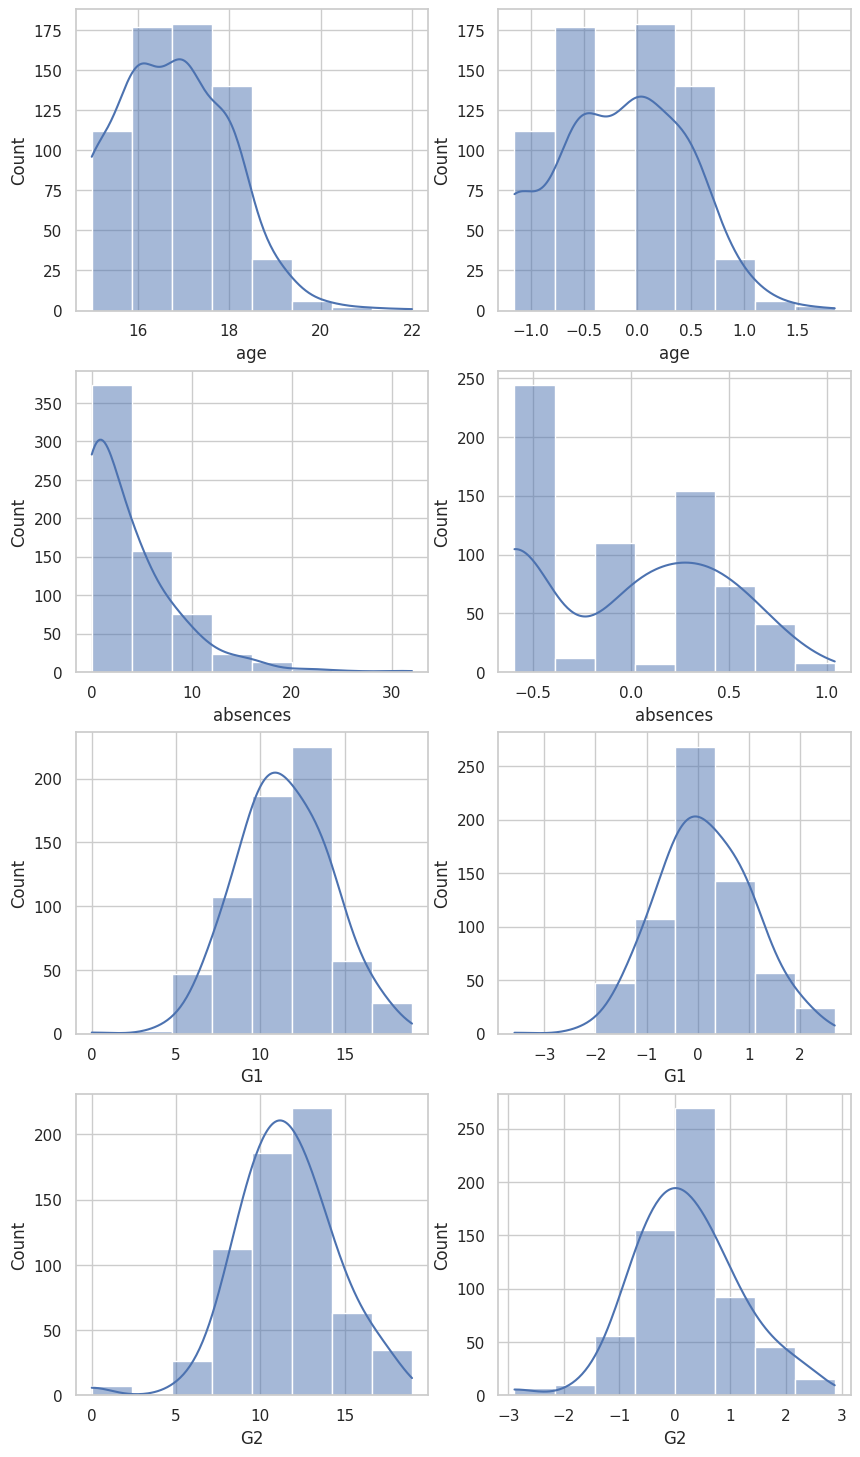

In [422]:
fig, axis = plt.subplots(4,2, figsize = (10,18))
for i in range(4):
    sns.histplot(df[numerical_var[i]], bins = 8, ax = axis[i][0], kde = True, kde_kws = {'bw_adjust' : 1.45})
    sns.histplot(df_preprocessed[numerical_var[i]], bins = 8, ax = axis[i][1], kde = True, kde_kws = {'bw_adjust' : 1.45})


As you can see box-cox could not make the absences gaussian-like :(  (See [this](https://stats.stackexchange.com/questions/581595/box-cox-transform-doesnt-make-data-normal))

np.float64(3.9610548759712716e-07)

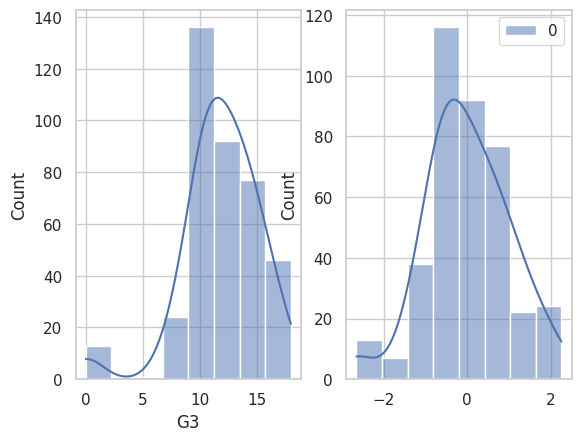

In [423]:
fig, axis = plt.subplots(1,2)
sns.histplot(y_train_old, bins = 8, ax = axis[0], kde = True, kde_kws = {'bw_adjust' : 1.45})
sns.histplot(y_train, bins = 8, ax = axis[1], kde = True, kde_kws = {'bw_adjust' : 1.45})

stats.shapiro(y_train).pvalue

Not normal yet :(

# Modeling

In [424]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

First we play with `LinearRegression` and then in the improving section we create other regressors.

In [425]:
model = Pipeline([
    ('preproc', preprocessor1),
    ('regressor', LinearRegression())
])

model.fit(X_train,y_train)

,steps,"[('preproc', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('column_trans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('nom', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3


In [426]:

print("\n--- Model Parameters ---")
print(f"Intercept (b): {model['regressor'].intercept_[0]:.4f}")

coefficients = pd.DataFrame(
    data=model['regressor'].coef_.T, 
    index=model['preproc'].get_feature_names_out(), 
    columns=['Coefficient']
)

coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
print("\nModel Coefficients (w):")
print(coefficients.sort_values(by='Abs_Coefficient', ascending=False))


--- Model Parameters ---
Intercept (b): -0.0273

Model Coefficients (w):
                   Coefficient  Abs_Coefficient
G2                    0.812123         0.812123
G1                    0.192234         0.192234
Mjob_other           -0.089061         0.089061
Mjob_health           0.087737         0.087737
Fjob_at_home          0.074237         0.074237
traveltime            0.067031         0.067031
failures             -0.061220         0.061220
reason_other         -0.058051         0.058051
school_MS            -0.056297         0.056297
school_GP             0.056297         0.056297
Mjob_at_home         -0.055063         0.055063
age                   0.047513         0.047513
reason_course         0.045657         0.045657
paid_yes             -0.041951         0.041951
paid_no               0.041951         0.041951
Mjob_teacher          0.039708         0.039708
guardian_other        0.037618         0.037618
romantic_no          -0.033923         0.033923
romantic_yes  

In [427]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [428]:
pd.DataFrame(y_transformer.inverse_transform(y_pred_test)).describe()

,0
count,260.000000
mean,12.092836
std,2.884457
min,-1.702922
25%,10.012626
50%,12.011682
75%,13.818615
max,19.100531


We have negative predictions in our model, which is not good, since grade can not be negative.

In [429]:
print("\n--- Model Evaluation ---")
print("Test Set Performance:")

y_pred_test_orig = y_transformer.inverse_transform(y_pred_test)

r2_test = r2_score(y_test, y_pred_test_orig)
print(f"  R-squared (R²): {r2_test:.4f}")

mae_test = mean_absolute_error(y_test, y_pred_test_orig)
print(f"  Mean Absolute Error (MAE): {mae_test:,.2f}")

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_orig))
print(f"  Root Mean Squared Error (RMSE): {rmse_test:,.2f}")

print("\nTrain Set Performance (for comparison):")

r2_train = r2_score(y_train, y_pred_train)
print(f"  R-squared (R²): {r2_train:.4f}")

y_pred_train_orig = y_transformer.inverse_transform(y_pred_train)
mae_train = mean_absolute_error(y_train_old, y_pred_train_orig)
print(f"  Mean Absolute Error (MAE): {mae_train:,.2f}")


--- Model Evaluation ---
Test Set Performance:
  R-squared (R²): 0.8525
  Mean Absolute Error (MAE): 0.80
  Root Mean Squared Error (RMSE): 1.17

Train Set Performance (for comparison):
  R-squared (R²): 0.8984
  Mean Absolute Error (MAE): 0.79


Looks good to me!

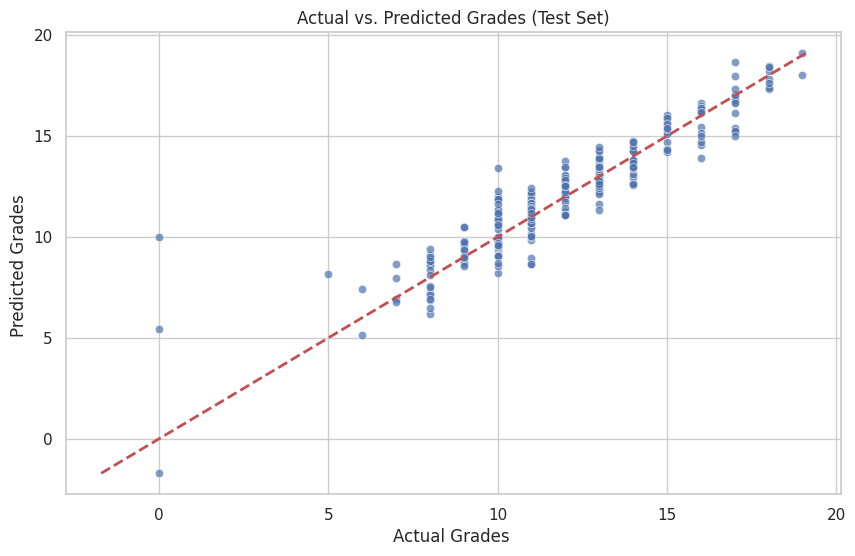

In [430]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test_orig[:,0], alpha=0.7)

min_val = min(y_test.min(), y_pred_test_orig.min())
max_val = max(y_test.max(), y_pred_test_orig.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.xlabel("Actual Grades ")
plt.ylabel("Predicted Grades ")
plt.title("Actual vs. Predicted Grades (Test Set)")
plt.show()

# Improving The Model

In [431]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

We are going to create different regressors.

In [432]:
def evaluate_model(model_name, model, X_test, y_test, verbose = True):
    """
    Makes predictions and prints evaluation metrics (R², MAE, RMSE).
    Handles the inverse transform for error metrics.
    """
    if verbose:
        print(f"--- Evaluating Model: {model_name} ---")
    try:
        y_pred = y_transformer.inverse_transform(model.predict(X_test))
    except ValueError:
        y_pred = y_transformer.inverse_transform(model.predict(X_test)[:, None])

    r2 = r2_score(y_test, y_pred)
    if verbose:
        print(f"  R-squared (R²): {r2:.4f}")

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    if verbose:
        print(f"  Mean Absolute Error (MAE): {mae:,.2f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse:,.2f}\n")
    
    return r2, mae, rmse

In [433]:
model_performance = {}

r2, mae, rmse = evaluate_model("Baseline Linear Regression", model, X_test, y_test)
model_performance['Baseline_Linear'] = (r2, mae)

--- Evaluating Model: Baseline Linear Regression ---
  R-squared (R²): 0.8525
  Mean Absolute Error (MAE): 0.80
  Root Mean Squared Error (RMSE): 1.17



In [434]:
print("Building Ridge (L2) Regularization Model...")

ridge_pipe = Pipeline([
    ('preproc', preprocessor1),
    ('model', Ridge())  # alpha=1.0 is a common default to start with. A higher alpha = a stronger penalty / simpler model.
])

ridge_pipe.fit(X_train, y_train)

r2, mae, rmse = evaluate_model("Ridge Regression (L2)", ridge_pipe, X_test, y_test)
model_performance['Ridge_L2'] = (r2, mae)

Building Ridge (L2) Regularization Model...
--- Evaluating Model: Ridge Regression (L2) ---
  R-squared (R²): 0.8532
  Mean Absolute Error (MAE): 0.80
  Root Mean Squared Error (RMSE): 1.17



In [435]:
print("Building Lasso (L1) Regularization Model...")

lasso_pipe = Pipeline([
    ('preproc', preprocessor1),
    ('model', Lasso(alpha=0.01))
])

lasso_pipe.fit(X_train, y_train)

r2, mae, rmse = evaluate_model("Lasso Regression (L1)", lasso_pipe, X_test, y_test)
model_performance['Lasso_L1'] = (r2, mae)

lasso_coefs = lasso_pipe.named_steps['model'].coef_

coef_df = pd.DataFrame(
    data=lasso_coefs, 
    index=model['preproc'].get_feature_names_out(), 
    columns=['Coefficient']
)

print("Lasso Coefficients:")
print(coef_df.sort_values(by='Coefficient', ascending=False))

Building Lasso (L1) Regularization Model...
--- Evaluating Model: Lasso Regression (L1) ---
  R-squared (R²): 0.8657
  Mean Absolute Error (MAE): 0.74
  Root Mean Squared Error (RMSE): 1.12

Lasso Coefficients:
                    Coefficient
G2                 8.175715e-01
G1                 1.880894e-01
school_GP          6.419118e-02
traveltime         2.498268e-02
age                2.420437e-02
reason_course      1.511326e-02
romantic_yes       4.925321e-18
sex_F              0.000000e+00
sex_M             -0.000000e+00
Fjob_services     -0.000000e+00
address_U          0.000000e+00
Pstatus_T         -0.000000e+00
Pstatus_A          0.000000e+00
Mjob_health        0.000000e+00
Mjob_services      0.000000e+00
Mjob_teacher       0.000000e+00
Mjob_at_home      -0.000000e+00
reason_home        0.000000e+00
Fjob_at_home       0.000000e+00
Fjob_other         0.000000e+00
Fjob_health       -0.000000e+00
Fjob_teacher      -0.000000e+00
reason_reputation -0.000000e+00
address_R         -0.

In [436]:
print("Building Polynomial Regression Model...")

poly_pipe = Pipeline([
    ('preproc', preprocessor1),
    ('poly_features', ColumnTransformer([('poly', PolynomialFeatures(degree=2, include_bias=False), [0,1,2,4])], remainder='passthrough')),
    # 'degree=2' is standard. degree=3 or higher will likely overfit.
    ('model', LinearRegression())
])

poly_pipe.fit(X_train, y_train)

r2, mae, rmse = evaluate_model("Polynomial Regression (Degree 2)", poly_pipe, X_test, y_test)
model_performance['Polynomial_D2'] = (r2, mae)

Building Polynomial Regression Model...
--- Evaluating Model: Polynomial Regression (Degree 2) ---
  R-squared (R²): 0.8357
  Mean Absolute Error (MAE): 0.83
  Root Mean Squared Error (RMSE): 1.23



In [437]:
print("Building Polynomial + Ridge Regression Model...")

poly_ridge_pipe = Pipeline([
    ('preproc', preprocessor1),
    ('poly_features', ColumnTransformer([('poly', PolynomialFeatures(degree=2, include_bias=False), [0,1,2,4])], remainder='passthrough')),
    ('model', Ridge(alpha=10.0)) # We use a stronger alpha to control the many new features
])

poly_ridge_pipe.fit(X_train, y_train)

r2, mae, rmse = evaluate_model("Polynomial (D2) + Ridge (alpha=10)", poly_ridge_pipe, X_test, y_test)
model_performance['Poly_Ridge'] = (r2, mae)

Building Polynomial + Ridge Regression Model...


--- Evaluating Model: Polynomial (D2) + Ridge (alpha=10) ---
  R-squared (R²): 0.8499
  Mean Absolute Error (MAE): 0.79
  Root Mean Squared Error (RMSE): 1.18



In [438]:
print("--- Final Model Comparison ---")

results_df = pd.DataFrame.from_dict(
    model_performance, 
    orient='index', 
    columns=['R_squared', 'Mean_Absolute_Error']
)

print(results_df.sort_values(by='R_squared', ascending=False))
print(y_test.shape)

--- Final Model Comparison ---
                 R_squared  Mean_Absolute_Error
Lasso_L1          0.865654             0.737987
Ridge_L2          0.853246             0.796568
Baseline_Linear   0.852522             0.800689
Poly_Ridge        0.849866             0.793539
Polynomial_D2     0.835725             0.829281
(260,)


# Final Model

Now, we combine different models with different preprocessors to see which one is the best!

In [443]:
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor


Recall that :

- preprocessor2 has a different transformer.
- preprocessor3 has a different scaler.
- preprocessor4 has a different encoder.

In [464]:
y = df['G3']

X = df.drop('G3', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.86,     
    random_state=5
)

y_transformer = PowerTransformer()

y_train_old, y_train = y_train.copy(), (pd.DataFrame(y_transformer.fit_transform(pd.DataFrame(y_train))))

print(f"Training set shape (X): {X_train.shape}")
print(f"Testing set shape (X): {X_test.shape}")

Training set shape (X): (90, 32)
Testing set shape (X): (559, 32)


![](pic/rich-poor-meme.jpg)



![](pic/let-him-cook-meme.jpeg)

                 R_squared        MAE        RMSE Preprocessor Regressor
pre1_elastic      0.835164   0.800590    1.306565         pre1   elastic
pre4_elastic      0.833037   0.804953    1.314968         pre4   elastic
pre4_lasso        0.824176   0.791813    1.349408         pre4     lasso
pre1_ridge        0.793783   0.939734    1.461394         pre1     ridge
pre4_rf           0.783922   0.998774    1.495924         pre4        rf
pre3_rf           0.780249   1.011032    1.508587         pre3        rf
pre1_rf           0.779402   1.004076    1.511489         pre1        rf
pre3_elastic      0.776753   0.829888    1.520537         pre3   elastic
pre4_ridge        0.776198   0.967058    1.522428         pre4     ridge
pre1_lasso        0.771477   0.825413    1.538400         pre1     lasso
pre2_rf           0.768109   1.043017    1.549698         pre2        rf
pre2_lasso        0.766104   0.914819    1.556381         pre2     lasso
pre2_elastic      0.759021   0.938183    1.579771  

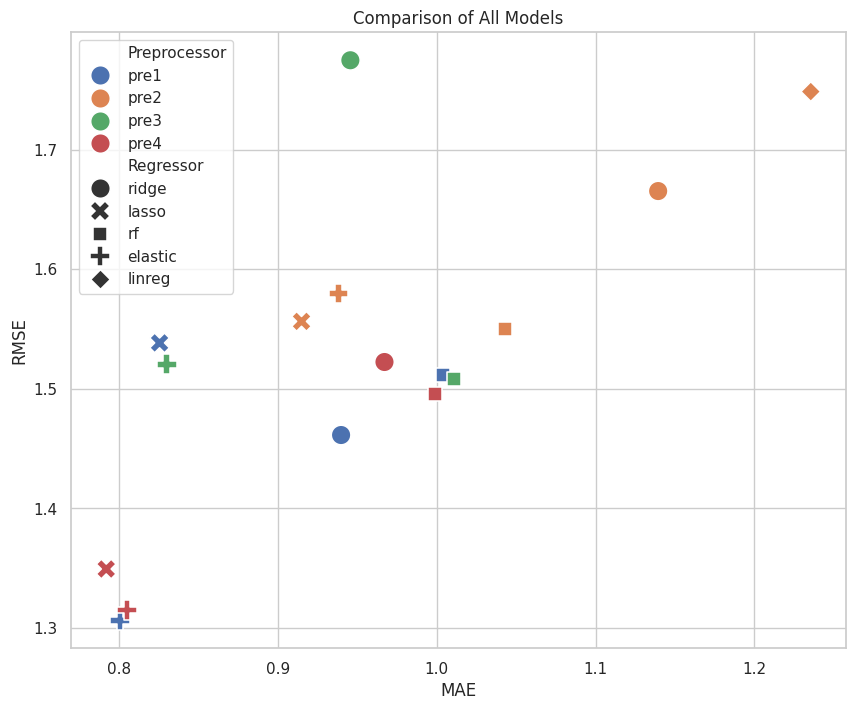

In [465]:

def remove_outliers(df):
    return df[(df['RMSE']<2) & (df['MAE']<2)]
preprocessors = { 'pre1' : preprocessor1, 'pre2' : preprocessor2, 'pre3' : preprocessor3, 'pre4' : preprocessor4}
regressors = { 'linreg' : LinearRegression(), 'ridge' : RidgeCV(),  'lasso' : LassoCV(), 'rf' : RandomForestRegressor(), 'dt' : DecisionTreeRegressor(), 'elastic' : ElasticNetCV()}

def RunAllModels(pres,regs):
    mp = {} # model performance
    for pre_name,pre in pres.items():
        for reg_name,reg in regs.items():
            model = Pipeline([
                ('preproc', pre),
                ('model', reg) 
            ])
            model.fit(X_train,y_train)
            mp[pre_name+'_'+reg_name] = evaluate_model("model", model, X_test, y_test, verbose=False)+(pre_name,reg_name)
            #print(pre_name,reg_name)
    return mp

            
res = RunAllModels(preprocessors,regressors)
results_df = pd.DataFrame.from_dict(
    res, 
    orient='index', 
    columns=['R_squared', 'MAE', 'RMSE', 'Preprocessor', 'Regressor']
)
fig,ax = plt.subplots(figsize=(10,8))
sns.scatterplot(remove_outliers(results_df),x="MAE",y="RMSE", hue = 'Preprocessor', style = 'Regressor', s =200)
ax.set(title="Comparison of All Models")
print(results_df.sort_values(by='R_squared', ascending=False))

Now let's watch some memes together!

![](pic/gru-meme.jpeg)

![](pic/car-meme.jpg)

![](pic/noah-meme.jpg)

![](pic/red-woman-meme.jpeg)

# Fun Facts

You can skip this part if you're not interested!

Fun Fact Number x := FFNx

### FFN1
 Here are the pictures of those two schools in the first column of the dataset:

|![](pic/GP.jpg)<br>Gabriel Pereira|![](pic/MS.jpg)<br>Mousinho da Silveira|
|:-:|:-:|


### FFN2

My models had accuracy of above 80% even with 80% test dataset when random_state was 7. I changed it.